# Data Driven ABM

Attempting to tie model parameters and outcomes to real world data.

## Need, Unmet Need, and Base Rates

Making use of ELSA data to derive base rates in the population for those in need of in home care, and those in need who do not receive it.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
%load_ext rpy2.ipython

/usr/local/lib/python2.7/site-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


Load the data from STATA format, recode variables for mobility, ADL, IADL to NA, True, False

In [2]:
%%R
library(foreign)
library(survey)
library(plyr)
elsa_4 <- read.dta("elsa/UKDA-5050-stata11_se/stata11_se/wave_4_elsa_data_v3.dta")
elsa_4$mobility_need <- as.logical(mapvalues(elsa_4$hemob96, c("Mentioned", "Not mentioned", "Refusal", "Don't Know", "Schedule not applicable", "Item not applicable"), c(F, T, NA, NA, NA, NA)))
elsa_4$adl_need <- as.logical(mapvalues(elsa_4$headl96, c("Mentioned", "Not mentioned", "Refusal", "Don't Know", "Schedule not applicable", "Item not applicable"), c(F, T, NA, NA, NA, NA)))
elsa_4$need <- elsa_4$mobility_need | elsa_4$adl_need #This isn't ideal, but there happen to be no NA values here.
elsa_4$help <- as.logical(mapvalues(elsa_4$hehpa, c("Yes", "No", "Refusal", "Don't Know", "Schedule not applicable"), c(T, F, NA, NA, NA)))

Loading required package: grid

Attaching package: 'survey'

The following object is masked from 'package:graphics':

    dotchart



Using ELSA wave 4, loaded using the survey package. Specifically interested in the 65+ age group, so next we produce a subset of the full sample.

In [4]:
%%R
elsa_4.svy <- svydesign(~idauniq, data=elsa_4, weights=~w4xwgt)
elsa_4.svy.65plus <- subset(elsa_4.svy, indager > 64);

Error in withVisible({ : could not find function "svydesign"


Proportion of the population with a mobility, ADL or IADL need.

In [5]:
%%R 
svymean(~need, design=elsa_4.svy.65plus)

Error in withVisible({ : could not find function "svymean"


This suggests that the proportion of over 65s with some need for support is relatively high, at 70.5%.
Of those in need, ELSA also asks if they receive any support.

In [6]:
%%R 
svyby(~help, ~need, design=elsa_4.svy.65plus, FUN=svymean)

Error in withVisible({ : could not find function "svyby"


Which suggests that a slight majority of 52.8% receive no assistance.

We can also look at some specific ADL needs: washing, and dressing. Coded as headlba, and headldr in the ELSA dataset. (Following http://www.palgrave-journals.com/pt/journal/v145/n1/pdf/pt201117a.pdf)

In [7]:
%%R 
svytable(~headldr+headlba, design=elsa_4.svy.65plus, Ntotal=100)

Error in withVisible({ : could not find function "svytable"


From this, we can see that ~ 74.8% don't need help with either, 6.5% need help only with washing, 9.7% need help only with dressing, and 9% require support with both.

ELSA also asks whether people receive support with these tasks specifically.

In [8]:
%%R
svyby(~hehpw96, ~headlba+headldr, elsa_4.svy.65plus, svymean)

Error in withVisible({ : could not find function "svyby"


This suggests that 38.6% of those who only need help washing receive support, 34% of those who need assistance to dress themselves, and 68.3% of those needing support for both.
We can also look at an amalgamated version of this, where we combine both need groups.

In [9]:
%%R
elsa_4$adlneed <- (elsa_4$headlba == "Mentioned") | (elsa_4$headldr == "Mentioned")
elsa_4.svy <- svydesign(~idauniq, data=elsa_4, weights=~w4xwgt)
elsa_4.svy.65plus <- subset(elsa_4.svy, indager > 64)
print(svyby(~hehpw96, ~adlneed, design=elsa_4.svy.65plus, FUN=svymean))
print(svytable(~adlneed, design=elsa_4.svy.65plus, Ntotal=100))

Error in withVisible({ : could not find function "svydesign"


This suggests that a little over a quarter would fall into an amalgamated need group, with 47.5% of them receiving assistance.

## Synthetic Psychologies

It is also necessary to derive some basis for the prior beliefs of the agent populations, covering their expectations of receiving help, belief that they will be stigmatised for requesting it, and in the case of the assessors, how trusting they are.

### Expectations

Resignation, and a lack of belief that support will be offered, or make a practical difference if it is, is a key obstacle to help seeking behaviour in the older population.

Two sources are available to explore these beliefs - ZA4561: Eurobarometer 67.3: Health Care Service, Undeclared Work, EU Relations With Its Neighbor Countries, and Development Aid, May-June 2007, and the ONS OPN MCE surveys from 2009-11. Both ask if the respondent believes they will receive appropriate support if they require long term care.

#### Eurobarometer

As before, we are interested in the over 65 age group, and derive a subset accordingly.

The question text is "In the future do you think that you would be provided with the appropriate help and long-term care if you were to need it?", coded as v184 in the dataset.

Since Eurobarometer covers several countries, we also use the UK specific weights (v10).

In [10]:
%%R
eb <- read.dta("beliefs/Eurobarometer/ZA4561_v2-1-0.dta")
eb.svy <- svydesign(~v5, data=eb, weights=~v10)
eb.svy.65plus <- subset(eb.svy, v584 > 64)
svymean(~v184, eb.svy.65plus, na.rm=T)

Error in withVisible({ : could not find function "svydesign"
In addition: Warning message:
In read.dta("beliefs/Eurobarometer/ZA4561_v2-1-0.dta") :
  value labels ('V700') for 'v700' are missing
Error in withVisible({ : could not find function "svydesign"


This suggests that the majority of people (75.5%) do believe they will receive the right care, but only a minority are certain of this.

In parameterisation terms, we can interpret this as equating to a distribution of pseudocounts, where ~26% of the population have a strong prior in favour, 49% a weak prior in favour, and so forth. Naturally, while this gives valence, and is suggestive of relative magnitude, it does not provide a measure of how much weight the prior is assigned.

#### ONS OPN

The OPN surveys are slightly more complex, as they cover a time period of approximately a year (we have collated the surveys into a single file, for convenience), and do not precisely correspond to the Eurobarometer question in that they are a binary choice with a "Don't know" option.

Question text "Can older people get the services they need to continue to live at home?"

In [11]:
%%R
ops <- read.csv("beliefs/OPS/MCE/mce.csv", header=T)
ops$MCE_1 <- mapvalues(ops$MCE_1, c(1, 2, 3, 8), c("Yes", "No", "DK", NA))
ops.svy <- svydesign(~casenumber, data=ops, weights=~indwgt)
ops.svy.65plus <- subset(ops.svy, rage > 64)
svymean(~MCE_1, ops.svy.65plus, na.rm=T)

Error in withVisible({ : could not find function "mapvalues"


This suggests a slightly less encouraging picture, in that while a majority of respondents still believe they can get the right care, this is reduced to 59.3%. The differing response structure may account for some of this difference, as may the change in government, and recession that occurred between the survey periods.

Looking at this as a parameter, we can approach it as suggesting probabilities of positively and negatively valenced psuedocounts, with 26% of the population having an uninformative prior. Magnitude is, again, not derivable from the data.

### Stigma

Stigma is difficult to quantify, and whether the inhibitory factor should even be referred to as such is uncertain - it might equally represent the disutility associated with loss of social identity, or the concern of being a burden.

With this said, we can make some assessment of how far the over 65 population expects to be regarded by others. To this end, we make use of wave 4 of the ESS (2008), which contained a special section on ageing.

In [12]:
%%R
ess <- read.dta("payoffs/social\ costs/ESS/ESS4GB.stata/ESS4GB.dta")

Wave 4 of the ESS contains several likert scale items relevant to this situation, which assess what the respondent belives the attitude of the majority of society is towards those in their 70s.
We approach these on the basis that they are true likert scale items, and combine them to form a likert scale.
Specifically, this are of the form "Most people view those over 70.."

    As
        Competent (v70comp)
        Friendly (v70frnd)
        Having high moral standards (v70mrst)
    With
        Pity (v70pity)
        Envy (v70envy)
        Contempt (v70cntm)
        Respect (v70resp)
        Admiration (v70adm)

All coded as 0-4 from not at all likely, to very likely to be viewed as such. We exclude cases where the respondent refused to answer, didn't know, or gave no answer to any of the questions. Since pity, envy, and contempt are negative attitudes, we invert the scales for these measures. We can then derive a scale either by taking the average of scale items for each respondent, or by summation.

In [13]:
%%R
mapfrom <- c("Not at all likely to be viewed that way", "Very likely to be viewed that way", "Refusal", "Don't know", "No answer")
mapto <- c(0, 4, NA, NA, NA)
ess$v70comp <- as.numeric(as.character(mapvalues(ess$v70comp, mapfrom, mapto)))
ess$v70frnd <- as.numeric(as.character(mapvalues(ess$v70frnd, mapfrom, mapto)))
ess$v70mrst <- as.numeric(as.character(mapvalues(ess$v70mrst, mapfrom, mapto)))
ess$v70pity <- as.numeric(as.character(mapvalues(ess$v70pity, mapfrom, mapto)))
ess$v70envy <- as.numeric(as.character(mapvalues(ess$v70envy, mapfrom, mapto)))
ess$v70cntm <- as.numeric(as.character(mapvalues(ess$v70cntm, mapfrom, mapto)))
ess$v70resp <- as.numeric(as.character(mapvalues(ess$v70resp, mapfrom, mapto)))
ess$v70adm <- as.numeric(as.character(mapvalues(ess$v70adm, mapfrom, mapto)))

Error in withVisible({ : could not find function "mapvalues"
In addition: Warning messages:
1: In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels,  :
  duplicated levels in factors are deprecated
2: In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels,  :
  duplicated levels in factors are deprecated
Error in withVisible({ : could not find function "mapvalues"


Before combining the items, we should check the validity of doing so by calculating Cronbach's alpha for the combination.

In [14]:
%%R
library(ltm)
df <- ess[,c("v70comp", "v70frnd", "v70mrst", "v70pity", "v70envy", "v70cntm", "v70resp", "v70adm")]
print(descript(df)$alpha)

Error in library(ltm) : there is no package called 'ltm'


An &alpha; value of 0.6 is not ideal, and could be improved by discarding the negative measures (this is unsuprising, given that a high rating would seem to imply the opposite to a high rating on a positive dimension.)

Alternatively, we could deal with them as in The association between ageism and subjective age of older people in Europe, and invert them. Or, we could retain them and use a latent trait approach.

In [15]:
%%R
ess$v70pityi <- 4 - ess$v70pity
ess$v70envyi <- 4 - ess$v70envy
ess$v70cntmi <- 4 - ess$v70cntm
ess$stigma_mean <- rowMeans(ess[,c("v70comp", "v70frnd", "v70mrst", "v70pityi", "v70envyi", "v70cntmi", "v70resp", "v70adm")])
ess$stigma_sum <- (apply(ess[,c("v70comp", "v70frnd", "v70mrst", "v70pityi", "v70envyi", "v70cntmi", "v70resp", "v70adm")], 1, sum))

ess.svy <- svydesign(~idno, data=ess, weights=~pspwght)
ess.svy.65plus <- subset(ess.svy, agea > 64)
svymean(~stigma_mean, design=ess.svy.65plus, na.rm=T)

Error in rowMeans(ess[, c("v70comp", "v70frnd", "v70mrst", "v70pityi",  : 
  'x' must be numeric
In addition: Warning messages:
1: In Ops.factor(4, ess$v70pity) : '-' not meaningful for factors
2: In Ops.factor(4, ess$v70envy) : '-' not meaningful for factors
3: In Ops.factor(4, ess$v70cntm) : '-' not meaningful for factors
Error in rowMeans(ess[, c("v70comp", "v70frnd", "v70mrst", "v70pityi",  : 
  'x' must be numeric


The mean of averaged attitudes, at 2.7/4 suggests a tendency to believe that the majority of the population is relatively positive towards older adults.

In [16]:
%%R
svymean(~stigma_sum, design=ess.svy.65plus, na.rm=T)

Error in withVisible({ : could not find function "svymean"


We can also explore the distribution of perceived ratings.

In [17]:
%%R
svyhist(~stigma_mean, design=ess.svy.65plus)
lines(svysmooth(~stigma_mean, ess.svy.65plus))

svyhist(~stigma_sum, design=ess.svy.65plus)
lines(svysmooth(~stigma_sum, ess.svy.65plus))

Error in withVisible({ : could not find function "svyhist"


This looks reasonably close to a (skewed) normal distribution, which we can check further with a qq-plot.

In [18]:
%%R
qqnorm(subset(ess, agea > 64)$stigma_mean);qqline(subset(ess, agea > 64)$stigma_mean, col = 2)
qqnorm(subset(ess, agea > 64)$stigma_sum);qqline(subset(ess, agea > 64)$stigma_sum, col = 2)

Error in qqnorm.default(subset(ess, agea > 64)$stigma_mean) : 
  y is empty or has only NAs
In addition: Warning message:
In is.na(y) : is.na() applied to non-(list or vector) of type 'NULL'
Error in qqnorm.default(subset(ess, agea > 64)$stigma_mean) : 
  y is empty or has only NAs


The QQ-plot clearly indicates that the data is not quite normal, but is relatively close.
We can also test for non-normality using Shapiro-Wilks, and look at skew and kurtosis.

In [19]:
%%R
library(moments)
print(shapiro.test(subset(ess, agea > 64)$stigma_mean))
print(skewness(subset(ess, agea > 64)$stigma_mean, na.rm=T))
print(kurtosis(subset(ess, agea > 64)$stigma_mean, na.rm=T))

Error in library(moments) : there is no package called 'moments'


The low p-value for the SW test, and the >0 skew suggest that a normal distribution may not be an ideal model for this parameter (but could be worse).

We can also try finding a better fitting distribution. (Possibly we should be treating this as censored data?)

In [20]:
%%R
library(fitdistrplus)
x <- subset(ess, agea > 64)
x <- x[!is.na(x$stigma_mean), "stigma_mean"]
hist(x)
hist(4-x)
ga <- fitdist(x, "gamma")
print(ga)
plot(ga)

l <- fitdist(x, "lnorm")
print(l)
plot(l)

n <- fitdist(x, "norm")
print(n)
plot(n)

Error in library(fitdistrplus) : 
  there is no package called 'fitdistrplus'


Both the gamma, and lognormal distributions appear to be reasonable fits, so we compare them.

In [21]:
%%R
f <- gofstat(list(ga, l, n))
print(f)
print(f$adtest)
print(f$kstest)

Error in withVisible({ : could not find function "gofstat"


None of the candidates pass a goodness of fit test, but this is not unexpected - we wouldn't anticipate the empirical data actually following one of the distributions. By eyeball, and by the metrics, the gamma distribution is the marginally better fit. This is also convenient, in having a lower bound of zero.

We can also examine the extent to which this set of questions is a good aggregate measure, using latent trait analysis, and the R ltm package's graded response model. (Following along the lines of http://www.r-bloggers.com/item-response-modeling-of-customer-satisfaction-the-graded-response-model/)
In fact, we're not as such interested in the individual item measures, but primarily in the underlying attitude - as such, distilling them to a latent trait may be a better parameterisation.

In [22]:
%%R
library(ltm)
df <- ess[, c("v70comp", "v70frnd", "v70mrst", "v70pity", "v70envy", "v70cntm", "v70resp", "v70adm", "agea","stigma_mean")]
f <- grm(df[,1:8])
pattern <- factor.scores(f, resp.pattern=df[,1:8])
df$trait <- pattern$score.dat$z1
print(qplot(trait, data=df, geom="density"))
print(qplot(trait, stigma_mean, data=df))

print(qplot(trait, data=subset(df, df$agea > 64), main="65+", geom="density"))
print(qplot(trait, stigma_mean, data=subset(df, df$agea > 64), main="65+"))


Error in library(ltm) : there is no package called 'ltm'


Ideally, we would like to be able to fit a distribution to this latent trait.

In [23]:
%%R
x <- (subset(df, df$agea > 64)$trait+4)/8
fit <- fitdist(x, "beta")
print(fit)
plot(fit)
f <- gofstat(fit)
print(f)
print(f$adtest)
print(f$kstest)

fitn <- fitdist(x, "norm")
fitg <- fitdist(x, "logis")
f <- gofstat(list(fitn, fitg))
print(f)
print(f$adtest)
print(f$kstest)
plot(fitg)
print(fitg)

Error in withVisible({ : could not find function "fitdist"


On this basis, the best fit would be a logistic distribution. We can operationalise this, by treating the draw as for x:1 ratio for/against stigma, depending on sign.

### Trust

Measuring trust is challenging at best, and how to measure the specific sort of interpersonal trust represented in the priors for signal-type mappings is non-obvious.
Constrained, as we are to existing data sources, we can attempt to approximate this using measures of generalised social trust. Happily, the 2008 ESS also provides a measure for this. Once again, this consists of several likert scale type items, which we will combine to form a scale.

Specifically -

"Using this card, generally speaking, would you say that most people can be trusted, or that you can't be too careful in dealing with people? Please tell me on a score of 0 to 10, where 0 means you can't be too careful and 10 means that most people can be trusted." (ppltrst)

"Using this card, do you think that most people would try to take advantage of you if they got the chance, or would they try to be fair?" (pplfair)

"Would you say that most of the time people try to be helpful or that they are mostly looking out for themselves?" (pplhlp)

Here, we are interested in the whole population, and work with the wider dataset. As before, refusals, don't knows, and no answers are treated as missing data and excluded.

In [24]:
%%R
mapto <- c(0, 10, NA, NA, NA)
ess$ppltrst <- as.numeric(as.character(mapvalues(ess$ppltrst, c("You can't be too careful", "Most people can be trusted", "Refusal", "Don't know", "No answer"), mapto)))
ess$pplfair <- as.numeric(as.character(mapvalues(ess$pplfair, c("Most people try to take advantage of me", "Most people try to be fair", "Refusal", "Don't know", "No answer"), mapto)))
ess$pplhlp <- as.numeric(as.character(mapvalues(ess$pplhlp, c("People mostly look out for themselves", "People mostly try to be helpful", "Refusal", "Don't know", "No answer"), mapto)))
print(descript(ess[,c("ppltrst", "pplfair", "pplhlp")])$alpha)
ess$trust <- rowMeans(ess[,c("ppltrst", "pplfair", "pplhlp")])
ess$trust_sum <- apply(ess[,c("ppltrst", "pplfair", "pplhlp")], 1, sum)
ess.svy <- svydesign(~idno, data=ess, weights=~pspwght)
svymean(~trust, ess.svy, na.rm=T)

Error in withVisible({ : could not find function "mapvalues"


In [25]:
%%R
svyhist(~trust, design=ess.svy)
lines(svysmooth(~trust, design=ess.svy))

Error in withVisible({ : could not find function "svyhist"


This looks much less like a normal distribution, with considerable skew.

A reasonable approximation might be the Weibull distribution, which we can fit using the fitdistrplus package. (I've scaled the lowest values up, to avoid difficulties with optimisation.)

In [26]:
%%R
print(qplot(ess$trust, geom="density"))
x <- ess[!is.na(ess$trust), "trust"]+1
wei<-fitdist(x,"weibull")
plot(wei)
print(wei)
ga <- fitdist(x, "gamma")
plot(ga)
print(ga)
norm <- fitdist(x, "norm")
plot(norm)
print(norm)
f <- gofstat(list(wei, ga, norm))
print(f)
print(f$adtest)
print(f$kstest)

Error in print(qplot(ess$trust, geom = "density")) : 
  could not find function "qplot"


I've also compared the Weibull fit to two other candidates (gamma, and normal). As with the stigma values, the goodness of fit tests fail, it is the better option.

As with stigma, we can look at this from a latent trait perspective. (Note that the latent trait measured here is arguably mistrust, with high ratings yielding low scores.)

In [27]:
%%R
t <- ess[,c("pplfair", "pplhlp", "ppltrst")]
ft <- grm(t)
pt <- factor.scores(ft, resp.pattern=t)
score <- pt$score.dat$z1
print(qplot(score, geom="density"))
print(qplot(rowMeans(t), score))
qqnorm(score);qqline(score, col = 2)
print(shapiro.test(score))
print(skewness(score, na.rm=T))
print(kurtosis(score, na.rm=T))
fitb <- fitdist((score+4)/8, "beta")
print(fitb)
plot(fitb)
fitg <- fitdist((score+4)/8, "logis")
fitn <- fitdist((score+4)/8, "norm")
fitc <- fitdist((score+4)/8, "cauchy")
fitl <- fitdist((score+4)/8, "lnorm")
f <- gofstat(list(fitb, fitn, fitg, fitc, fitl))
print(f)
print(f$adtest)
print(f$kstest)

print("unstandardized")
fitn <- fitdist(score, "norm")
fitc <- fitdist(score, "logis")
f <- gofstat(list(fitn, fitc))
print(f)
print(f$adtest)
print(f$kstest)
print(fitn)

Error in withVisible({ : could not find function "grm"


In keeping with the theme, none of the distributions is a perfect fit. However a normal distribution is the least bad.

Another, more time consuming alternative might be to fit a kernel distribution and sample from that. But that's not important at this juncture.

## The Cost of Care

Determining a reasonable value for the cost of care is, in a sense, relatively simple. Expenditure, and activity for PSS (Personal Social Services) are available for the majority of local authorities across the UK. We may then work with the aggregate - the average cost of providing a year of care to an individual.

It should be noted that this is potentially misleading, given large variability in how much care is required and received by individuals, and the cost of delivery.

With this caveat in mind, we examine HSCIC data for PSS from the year 2008.

In the 08/09 period, gross national expenditure on home care for over 65s was £2,022,861,000. However in this instance we are interested in the cost of delivering home care to one older adult for a year, as funded by local authorities. We can look at the average across England, and the distribution of cost for 150 LAs.

                          LA          Weekly           Annual     
 102 - Cumbria             :  1   Min.   : 54.81   Min.   : 2850  
 104 - Northumberland      :  1   1st Qu.:124.77   1st Qu.: 6488  
 106 - Gateshead           :  1   Median :150.22   Median : 7811  
 107 - Newcastle upon Tyne :  1   Mean   :151.55   Mean   : 7881  
 108 - North Tyneside      :  1   3rd Qu.:172.90   3rd Qu.: 8991  
 109 - South Tyneside      :  1   Max.   :369.68   Max.   :19223  
 (Other)                   :144                                   
[1] 2502.45
[1] 2032.425


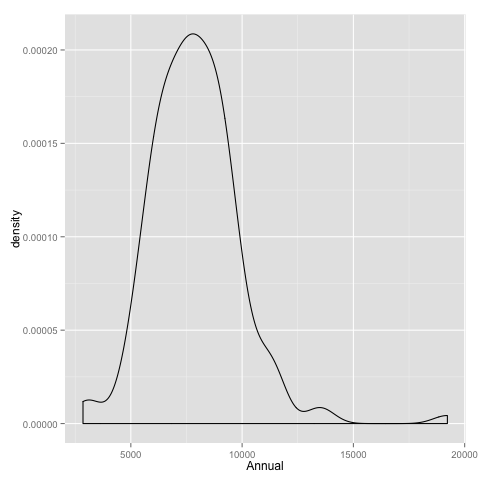

In [28]:
%%R
older <- read.csv("payoffs/referral\ costs/HSCIC/2008olderadults.csv", header=T)
library(ggplot2)
print(summary(older))
print(IQR(older$Annual))
print(sd(older$Annual))
print(qplot(Annual, data=older, geom="density"))

The average cost is around £7,800, but the standard deviation, IQR, and density plot all show that there is considerable national variation. While it may be reasonable to use a point estimate for the parameter, we can also explore fitting a distribution to the data.

In [29]:
%%R
qqnorm(older$Annual);qqline(older$Annual, col = 2)
print(shapiro.test(older$Annual))
lnorm <- fitdist(older$Annual, "lnorm")
plot(lnorm)
norm <- fitdist(older$Annual, "norm")
plot(norm)
f <- gofstat(list(norm, lnorm))
print(f)
print(f$adtest)
print(f$kstest)
print(lnorm)


	Shapiro-Wilk normality test

data:  older$Annual
W = 0.9269, p-value = 6.074e-07

Error in withVisible({ : could not find function "fitdist"


RRuntimeError: Error in dev.off() : 
  QuartzBitmap_Output - unable to open file '/tmp/tmp8Lo5cr/Rplots001.png'


A log normal distribution would appear to be a reasonable approximation for the distribution of care costs.

## Derived Parameters

|Parameter|Description|Value|Notes|Source|
|---------|-----------|-----|-----|------|
|p<sub>s</sub>(n)|Probability of a signaller needing support|0.70516|Covering any need|ELSA Wave 4|
|p<sub>s</sub>(n)|Probability of a signaller needing support|0.25174|Washing/dressing need only|ELSA Wave 4|
|X<sub>c</sub>|Cost to provide care for one year|7881|Mean value|Personal Social Services: Expenditure and Unit Costs, England, 2008/9. HSCIC|
|X<sub>c</sub>|Cost to provide care for one year|7811|Median value|Personal Social Services: Expenditure and Unit Costs, England, 2008/9. HSCIC|
|&alpha;<sub>referral</sub>|Belief in referral|Multinomial(YES=0.26386, yes=0.49122, no=0.17073, NO=0.07419)|3:1, 2:1 etc. multiplied by some constant k, maybe include noise here for ref by truth, ref by lie.[^1]|Eurobarometer|
|&alpha;<sub>referral</sub>||Multinomial(dk=0.26357, no=0.14288, yes=0.59355)||ONS OPN|
|&alpha;<sub>nice</sub>|Psuedocount of positive interactions|gamma(shape=37.29055, rate=13.95280)|Gamma distribution, drawing for x:1 prior bias multiplied by some constant k. Could make k an individual characteristic, drawn from a probability distribution, but have no evidence to draw from there.|ESS|
|&alpha;<sub>nice</sub>|"| logistic(location=0.5025573,scale=0.0630946)| Logistic distribution, drawing for x:1 with sign indicating bias, based on latent trait.| ESS|
|&alpha;<sub>s==t</sub>|Psuedocount of honest/dishonest signals|normal(mean=0.0007080957,sd=0.9116370106)|Drawing for x:1 signal==type with sign indicating bias, based on latent trait.|ESS|

[^1]:Another option here would be to discard the split reasoning on referral and just have a referred yes-no.

## Parameter Generation

Now, we can use this information to generate some parameter sets. We will begin by generating an initial sensitivity analysis dataset, varying parameters we cannot derive from the data. A minimal interesting set of parameters might be these 9:

### Parameters to vary

|Parameter|Description|Notes|Range|
|---------|-----------|-----|-----|
|X<sub>h,g</sub>|Payoff for good quality of life|Likely to need to be in the same range as cost to refer.|0-10000|
|X<sub>h,b</sub>|Cost for poor quality of life|Needs to be between X<sub>s</sub> and X<sub>h,g</sub>|0-10000|
|X<sub>s</sub>|Social cost of asking for help from a punishing responder|Let's just say 0-10000 for a first look.|0-10000|
|w<sub>s</sub>|Weight of shared information for signallers|Bounded between 0 and 1, may as well say uniform.|0-1|
|w<sub>r</sub>|Weight of shared information for responders|"|
|q<sub>s</sub>|Probability of signallers sharing information|"|
|q<sub>r</sub>|Probability of responders sharing information|"|
|k<sub>s</sub>|Weight of priors for signallers|No obvious rationale for this, so say 1-100|1-100|
|k<sub>r</sub>|Weight of priors for responders|"|

If we employ a latin hypercube design, this implies a 9 dimensional sampling space, with 4 dimensions left as unit, 3 rescaled to 0-10,000; and 2 to 1-100.

We will begin with a 400 point, maximin design.

In [4]:
import disclosuregame
import disclosuregame.Agents.initors


def designpoint(x_hg, x_hb, x_s, w_s, w_r, q_s, q_r, k_s, k_r):
    point = {'game_args':{'referral_cost':7881,"baby_payoff":x_hg, "mid_baby_payoff":x_hb,
                           "mid_mid":x_s, "mid_low":0, "low_mid":0,"low_low":0,
                           "women_share_prob":q_s, "mw_share_prob":q_r},
                    'signaller_args':{"signals":[0, 1], "share_weight":w_s},
                    'responder_args':{"signals":[0, 1], "share_weight":w_r},
                    'mw_weights':[1., 0.], 
                    'women_weights':[.75, .25],
                    'signaller_initor':disclosuregame.Agents.initors.ebreferral_logisticstigma,
                    'responder_initor':disclosuregame.Agents.initors.normalresponder,
                    'signaller_init_args':{"prior_weight":k_s},
                    'responder_init_args':{"prior_weight":k_r},
                    'tag':"sa_1"}
    return point

def designpoint_sa2(x_hg, x_hb, x_s, w_s, w_r, q_s, q_r, k_s, k_r):
    point = {'game_args':{'referral_cost':7881,"baby_payoff":x_hg, "mid_baby_payoff":x_hb,
                           "mid_mid":x_s, "mid_low":0, "low_mid":0,"low_low":0,
                           "women_share_prob":q_s, "mw_share_prob":q_r},
                    'signaller_args':{"signals":[0, 1], "share_weight":w_s},
                    'responder_args':{"signals":[0, 1], "share_weight":w_r},
                    'mw_weights':[1., 0.], 
                    'women_weights':[.75, .25],
                    'signaller_initor':disclosuregame.Agents.initors.onsreferral_logisticstigma,
                    'responder_initor':disclosuregame.Agents.initors.normalresponder,
                    'signaller_init_args':{"prior_weight":k_s},
                    'responder_init_args':{"prior_weight":k_r},
                    'tag':"sa_1"}
    return point

In [2]:
from pyDOE import *

In [4]:
samples = lhs(9, samples=400, criterion="maximin")

In [5]:
designs = []
chunk = []
chunksize = 1
for design in samples:
    design[:3] *= 10000
    design[-2:] *= 100
    design = designpoint(*design.tolist())
    chunk.append(design)
    if chunksize is not None and len(chunk) >= chunksize:
        designs.append(chunk)
        chunk = []

In [6]:
len(designs)

400

In [3]:
from disclosuregame.experiments import args_write

In [8]:
#args_write(designs, "../experiments/sa_1/args", "sa_1")

In [9]:
cmds = []
cmd = '/home/jg1g12/pypy/bin/pypy run.py -R 25 -s %s -r %s --pickled-arguments /home/jg1g12/risky-aging-model/experiments/sa_1/args/sa_1_%d.args -f %d_sa_1 -i 1000 -d /scratch/jg1g12/%s_%s -g CarryingInformationGame --procs 1 --abstract-measures'
for s, r in [("SharingBayesianPayoffSignaller", "SharingBayesianPayoffResponder"), ("SharingLexicographicSignaller", "SharingLexicographicResponder"), ("SharingProspectSignaller", "SharingProspectResponder"), ("SharingSignaller", "SharingResponder")]:
    for i in range(len(designs)):
        cmds.append(cmd % (s, r, i, i, s, r))

In [10]:
with open("../experiments/sa_1/commands.txt", "w") as f:
    f.write("\n".join(cmds))

In [3]:
import cPickle
for i in range(400):
    with open("../experiments/sa_1/args/sa_1_%d.args" % i, "rb") as f:
        arg = cPickle.load(f)
        arg[0]['signaller_initor'] = disclosuregame.Agents.initors.onsreferral_logisticstigma
        with open("../experiments/sa_2/args/sa_2_%d.args" % i, "wb") as f2:
            cPickle.dump(arg, f2)

### Sharing Off

In [8]:
import cPickle
import numpy as np

samples = lhs(5, samples=400, criterion="maximin")
designs = []
chunk = []
chunksize = 1
for design in samples:
    design[:3] *= 10000
    design[-2:] *= 100
    design = np.insert(design, -2, [0., 0., 0., 0.])
    design = designpoint(*design.tolist())
    chunk.append(design)
    if chunksize is not None and len(chunk) >= chunksize:
        designs.append(chunk)
        chunk = []

args_write(designs, "../experiments/sa_3/args", "sa_3")
        
cmds = []
cmd = '/home/jg1g12/pypy/bin/pypy run.py -R 25 -s %s -r %s --pickled-arguments /home/jg1g12/risky-aging-model/experiments/sa_3/args/sa_3_%d.args -f %d_sa_3 -i 1000 -d /scratch/jg1g12/%s_%s -g CarryingInformationGame --procs 1 --abstract-measures'
for s, r in [("SharingBayesianPayoffSignaller", "SharingBayesianPayoffResponder"), ("SharingLexicographicSignaller", "SharingLexicographicResponder"), ("SharingProspectSignaller", "SharingProspectResponder"), ("SharingSignaller", "SharingResponder")]:
    for i in range(len(designs)):
        cmds.append(cmd % (s, r, i, i, s, r))
with open("../experiments/sa_3/commands.txt", "w") as f:
    f.write("\n".join(cmds))

Writing ../experiments/sa_3/args/sa_3_0.args
Writing ../experiments/sa_3/args/sa_3_1.args
Writing ../experiments/sa_3/args/sa_3_2.args
Writing ../experiments/sa_3/args/sa_3_3.args
Writing ../experiments/sa_3/args/sa_3_4.args
Writing ../experiments/sa_3/args/sa_3_5.args
Writing ../experiments/sa_3/args/sa_3_6.args
Writing ../experiments/sa_3/args/sa_3_7.args
Writing ../experiments/sa_3/args/sa_3_8.args
Writing ../experiments/sa_3/args/sa_3_9.args
Writing ../experiments/sa_3/args/sa_3_10.args
Writing ../experiments/sa_3/args/sa_3_11.args
Writing ../experiments/sa_3/args/sa_3_12.args
Writing ../experiments/sa_3/args/sa_3_13.args
Writing ../experiments/sa_3/args/sa_3_14.args
Writing ../experiments/sa_3/args/sa_3_15.args
Writing ../experiments/sa_3/args/sa_3_16.args
Writing ../experiments/sa_3/args/sa_3_17.args
Writing ../experiments/sa_3/args/sa_3_18.args
Writing ../experiments/sa_3/args/sa_3_19.args
Writing ../experiments/sa_3/args/sa_3_20.args
Writing ../experiments/sa_3/args/sa_3_21.arg

In [7]:
with open("../experiments/sa_3/args/sa_3_398.args") as f:
    print cPickle.load(f)

[{'women_weights': [0.75, 0.25], 'responder_initor': <function normalresponder at 0x10eea9cf8>, 'signaller_args': {'signals': [0, 1], 'share_weight': 0.0}, 'tag': 'sa_1', 'responder_args': {'signals': [0, 1], 'share_weight': 0.0}, 'signaller_initor': <function ebreferral_logisticstigma at 0x10eea9b90>, 'mw_weights': [1.0, 0.0], 'game_args': {'women_share_prob': 0.0, 'mid_baby_payoff': 1135.5471959098618, 'referral_cost': 7881, 'baby_payoff': 5530.093770631928, 'mid_low': 0, 'low_mid': 0, 'low_low': 0, 'mid_mid': 7734.383105653321, 'mw_share_prob': 0.0}, 'responder_init_args': {'prior_weight': 46.85209636828678}, 'signaller_init_args': {'prior_weight': 86.64873108962857}}]
